A última execução deste notebook foi em  26 de fevereiro de 2022, às 15∶44.

In [108]:
import requests
from requests.adapters import HTTPAdapter, Retry
from bs4 import BeautifulSoup
from unidecode import unidecode
from string import digits
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Aqui é realizado web scraping no site de quatro super mercados de Fortaleza para montagem de uma lista de nomes de produtos e suas categorias. O resultado final é armazenado em um arquivo csv.

# Função para tratamento dos nomes dos produtos
Primeiramente vamos criar uma função que transforma uma string deixando-a toda com caracteres minúsculos e
removendo dígitos, acentos e caracteres de pontuação. Também removeremos expressões que referem-se em unidades e
medidas, e não à natureza do produto em si.

In [109]:
pal_unidades = ['unidade','kg','caixa','litro','pacote','embalagem','frasco','cx','garrafa','preco','desconto',
                'vidro','bandeja','higienizado','higienizada','higienziada','higienizados','selecionada',
                'selecionado']
sg_unidades = ['g','un','l','ml','s']

def trata_str(string):
    regex = re.compile('[^a-zA-Z ]')
    nome_prod = regex.sub('',unidecode(string.translate(str.maketrans('', '', digits)).lower()))
    
    for sg in sg_unidades:
        nome_prod = nome_prod.replace(' ' + sg + ' ','')
        if nome_prod[(len(sg) +1) * -1:] == ' ' + sg:
            nome_prod = nome_prod[0:len(sg) * -1:]
    
    for palavra in pal_unidades:
        nome_prod = nome_prod.replace(palavra,'')
    
    nome_prod = re.sub(' +',' ',nome_prod) # Retirando espaços múltiplos.
    return nome_prod.strip()

# Dados de quatro supermercados situados em Fortaleza
Vamos ler os produtos disponívels em quatro supermercados para capturar categorias de produtos. Foram escolhidos mercados de Fortaleza pois a massa que estamos tratando trata-se de pedidos de feiras feitos nesta cidade, e podemos ter produtos ou termos específicos da região na nossa massa.

In [110]:
# Recebe uma lista de URLs e faz varredura de todos produtos nelas, retornando um dicionário com os produtos e suas
# categorias.
def busca_produtos1(lista_urls):
    headers = {"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:97.0) Gecko/20100101 Firefox/97.0"}
    prods = dict()
    qt_erros = int()

    s = requests.Session()
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
    s.mount('http://', HTTPAdapter(max_retries=retries))
    
    # Buscando categorias na páginas principal.
    for url_ent in lista_urls:
        url = url_ent + '/setores'
        print('-'*115)
        print(f"Tratando {url_ent}")
        print('-'*115)
        response = s.get(url,headers=headers)

        if response.ok:
            html = response.content.decode()
            soup = BeautifulSoup(html,'html.parser')
            links = soup.find_all('li')
    
            nomes_categorias = list()
            links_categorias = list()

            for link in links:
                nomes_categorias.append(link.get('id'))
                link_parcial = link.find_all('a')[0].get('href')
                links_categorias.append(url_ent + link_parcial[1:])
            print(f"Categorias lidas: {len(nomes_categorias)}.")
        else:
            print(f"ERRO {response.status_code} em {url}")
            qt_erros += 1
            
        # Buscando subcategorias nas páginas de categorias
        nomes_sub_cats = list()
        links_sub_cats = list()
        i = int()

        for link_cat in links_categorias:
            url = link_cat

            response = s.get(url,headers=headers)

            if response.ok:
                html = response.content.decode()
                soup = BeautifulSoup(html,'html.parser')
                links = soup.find_all('li')
    
                for link in links:
                    nomes_sub_cats.append(link.get('id'))
                    link_parcial = link.find_all('a')[0].get('href')
                    links_sub_cats.append(url_ent + link_parcial[1:])
                print(f"Tratou {nomes_categorias[i]}. Subcategorias lidas: {len(links)}.")
                i += 1
            else:
                print(f"ERRO {response.status_code} em {link_cat}")
                qt_erros += 1

        # Buscando produtos nas páginas de subcategorias
        sub_cats = list(zip(nomes_sub_cats,links_sub_cats)) # pos[0]: nome; pos[1]: link
        
        for sub_cat in sub_cats:
            url = sub_cat[1]
            response = s.get(url,headers=headers)

            if response.ok:
                html = response.content.decode()
                soup = BeautifulSoup(html,'html.parser')
                produtos = soup.find_all('div', class_='sc-eCssSg dCfzHX')
                for produto in produtos:
                    prods[trata_str(produto.text)] = sub_cat[0].split('/')[-1].replace('-',' ')
                print(f"Tratou {sub_cat[0]}. Produtos lidos: {len(produtos)}.")
            else:
                print(f"ERRO {response.status_code} em {sub_cat[1]}")
                qt_erros += 1
                
    print('-'*115)
    print('Final de processamento')
    print(f"Erros ao acessar urls: {qt_erros}")
    print(f"Total de produtos lidos: {len(prods)}")
    print('-'*115)
    return prods

dic_prods1 = busca_produtos1(['https://amercado.americanas.com.br/produtos/centerbox-conceito',
                           'https://amercado.americanas.com.br/produtos/hipermercado-big-bompreco-bezerra-de-menezes',
                           'https://amercado.americanas.com.br/produtos/pao-de-acucar-nautico',
                           'https://amercado.americanas.com.br/produtos/mercado-extra-rodoviaria'])

-------------------------------------------------------------------------------------------------------------------
Tratando https://amercado.americanas.com.br/produtos/centerbox-conceito
-------------------------------------------------------------------------------------------------------------------
Categorias lidas: 15.
Tratou ofertas. Subcategorias lidas: 5.
Tratou carnes-aves-e-peixes. Subcategorias lidas: 5.
Tratou mercearia. Subcategorias lidas: 13.
Tratou desconto-marcas. Subcategorias lidas: 5.
Tratou hortifruti. Subcategorias lidas: 5.
Tratou padaria-e-confeitaria. Subcategorias lidas: 7.
Tratou frios-e-laticinios. Subcategorias lidas: 5.
Tratou lacteos. Subcategorias lidas: 8.
Tratou bebidas. Subcategorias lidas: 9.
Tratou congelados. Subcategorias lidas: 6.
Tratou limpeza. Subcategorias lidas: 4.
Tratou higiene-e-beleza. Subcategorias lidas: 8.
Tratou utilidades-domesticas. Subcategorias lidas: 12.
Tratou petshop. Subcategorias lidas: 2.
Tratou bebe. Subcategorias lidas: 3

Tratou mercearia/doces-e-sobremesas. Produtos lidos: 688.
Tratou mercearia/alimentos-basicos. Produtos lidos: 317.
Tratou mercearia/cafes-e-chas. Produtos lidos: 314.
Tratou mercearia/massas-e-molhos. Produtos lidos: 299.
Tratou mercearia/conservas-e-enlatados. Produtos lidos: 180.
Tratou mercearia/temperos-e-condimentos. Produtos lidos: 465.
Tratou mercearia/barra-de-cereais. Produtos lidos: 49.
Tratou mercearia/biscoitos-e-salgadinhos. Produtos lidos: 700.
Tratou mercearia/sementes-nozes-frutas-secas. Produtos lidos: 17.
Tratou mercearia/cereais-graos-farinhas-funcionais. Produtos lidos: 59.
Tratou mercearia/suplementos. Produtos lidos: 27.
Tratou desconto-marcas/becel. Produtos lidos: 12.
Tratou desconto-marcas/cervejas-ambev. Produtos lidos: 58.
Tratou desconto-marcas/sorvetes-kibon. Produtos lidos: 22.
Tratou desconto-marcas/danone. Produtos lidos: 66.
Tratou desconto-marcas/verde-campo. Produtos lidos: 12.
Tratou desconto-marcas/ajinomoto. Produtos lidos: 148.
Tratou desconto-mar

Tratou padaria-e-confeitaria/paes. Produtos lidos: 580.
Tratou padaria-e-confeitaria/torradas-cruttons. Produtos lidos: 93.
Tratou padaria-e-confeitaria/geleias-cremes. Produtos lidos: 195.
Tratou padaria-e-confeitaria/matinais. Produtos lidos: 832.
Tratou padaria-e-confeitaria/bolos. Produtos lidos: 423.
Tratou padaria-e-confeitaria/doces-padaria. Produtos lidos: 42.
Tratou padaria-e-confeitaria/panettones. Produtos lidos: 39.
Tratou frios-e-laticinios/queijos-embutidos-peca. Produtos lidos: 4.
Tratou frios-e-laticinios/fatiados-e-aperitivos. Produtos lidos: 79.
Tratou frios-e-laticinios/embutidos-finos. Produtos lidos: 28.
Tratou frios-e-laticinios/frios-e-embutidos. Produtos lidos: 380.
Tratou frios-e-laticinios/queijos. Produtos lidos: 961.
Tratou frios-e-laticinios/fondue-queijo. Produtos lidos: 15.
Tratou lacteos/iogurtes-e-coalhadas. Produtos lidos: 751.
Tratou lacteos/requeijao. Produtos lidos: 100.
Tratou lacteos/cream-cheese. Produtos lidos: 30.
Tratou lacteos/sobremesas-lact

Tratou bebidas/destilados. Produtos lidos: 8.
Tratou congelados/sorvetes-sucos-e-sobremesas. Produtos lidos: 467.
Tratou congelados/petiscos-e-empanados. Produtos lidos: 177.
Tratou congelados/pratos-prontos. Produtos lidos: 326.
Tratou congelados/hamburguer. Produtos lidos: 94.
Tratou congelados/legumes-congelados. Produtos lidos: 42.
Tratou congelados/frutas-congeladas. Produtos lidos: 10.
Tratou limpeza/uso-geral. Produtos lidos: 285.
Tratou limpeza/roupas. Produtos lidos: 103.
Tratou limpeza/cozinha. Produtos lidos: 78.
Tratou limpeza/banheiro. Produtos lidos: 110.
Tratou higiene-e-beleza/higiene. Produtos lidos: 453.
Tratou higiene-e-beleza/corpo. Produtos lidos: 424.
Tratou higiene-e-beleza/cabelos. Produtos lidos: 243.
Tratou higiene-e-beleza/maos-e-pes. Produtos lidos: 28.
Tratou higiene-e-beleza/johnson-and-johnson. Produtos lidos: 31.
Tratou utilidades-domesticas/filme-pvc-sacos-plasticos. Produtos lidos: 25.
Tratou utilidades-domesticas/guardanapo-toalha-de-papel. Produtos l

# Captura de dados em sites específicos de feiras
Como os produtos ofertados em supermercados não são exatamente iguais aos ofertados em feiras, vamos acrescentar informação coletadas em sites específicos de feiras à nossa massa.

## Sos Feira
Fonte: https://www.sosfeira.com.br/.

In [111]:
def busca_produtos2(lista_urls):
    headers = {"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:97.0) Gecko/20100101 Firefox/97.0"}
    prods = dict()
    qt_erros = int()

    s = requests.Session()
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
    s.mount('http://', HTTPAdapter(max_retries=retries))
    
    for url_ent in lista_urls:
        print(f"Tratando {url_ent}")
        response = s.get(url_ent,headers=headers)

        if response.ok:
            html = response.content.decode()
            soup = BeautifulSoup(html,'html.parser')
            
            categ = soup.find_all('h1', class_='titulo cor-secundaria')
            categoria = categ[0].text
            
            produtos = soup.find_all('div', class_='imagem-produto has-zoom')
            for produto in produtos:
                produto = produto.find_all('img')[0].get('alt')
                
                produto = trata_str(produto)
                categoria = trata_str(categoria)
                prods[produto] = categoria
        else:
            print(f"ERRO {response.status_code} em {url_ent}")
            qt_erros += 1

    print('-'*115)
    print('Final de processamento')
    print(f"Erros ao acessar urls: {qt_erros}")
    print(f"Total de produtos lidos: {len(prods)}")
    print('-'*115)
    return prods


dic_prods2 = busca_produtos2(['https://www.sosfeira.com.br/frutas',
                            'https://www.sosfeira.com.br/verduras',
                            'https://www.sosfeira.com.br/legumes'])

Tratando https://www.sosfeira.com.br/frutas
Tratando https://www.sosfeira.com.br/verduras
Tratando https://www.sosfeira.com.br/legumes
-------------------------------------------------------------------------------------------------------------------
Final de processamento
Erros ao acessar urls: 0
Total de produtos lidos: 45
-------------------------------------------------------------------------------------------------------------------


## Verduranet
Fonte: https://www.verduranet.com/.

In [112]:
def busca_produtos3(lista_urls):
    headers = {"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:97.0) Gecko/20100101 Firefox/97.0"}
    prods = dict()
    qt_erros = int()

    s = requests.Session()
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
    s.mount('http://', HTTPAdapter(max_retries=retries))
    
    for url_ent in lista_urls:
        url = url_ent
        pag = 1
        response = s.get(url,headers=headers)

        while response.ok:
            print(f"Tratando {url}")
            html = response.content.decode()
            soup = BeautifulSoup(html,'html.parser')
            
            categ = soup.find_all('nav', class_='woocommerce-breadcrumb')[0]
            categoria = categ.text.replace('\t','').replace('\n','').replace('\r','').split('/')[1]
            
            produtos = soup.find_all('div', class_='product-name')
            for produto in produtos:
                produto = produto.find_all('h2')[0].text
                
                produto = trata_str(produto)
                categoria = trata_str(categoria)
                prods[produto] = categoria
                
            pag += 1
            url = url_ent + 'page/' + str(pag)
            response = s.get(url,headers=headers)
        else:
            print(f"Final de categoria com {url}")

    print('-'*115)
    print('Final de processamento')
    print(f"Total de produtos lidos: {len(prods)}")
    print('-'*115)
    return prods


dic_prods3 = busca_produtos3(['https://www.verduranet.com/product-category/vegetais/',
                              'https://www.verduranet.com/product-category/frutas/',
                              'https://www.verduranet.com/product-category/saladas/',
                              'https://www.verduranet.com/product-category/temperos/'])

Tratando https://www.verduranet.com/product-category/vegetais/
Tratando https://www.verduranet.com/product-category/vegetais/page/2
Tratando https://www.verduranet.com/product-category/vegetais/page/3
Tratando https://www.verduranet.com/product-category/vegetais/page/4
Final de categoria com https://www.verduranet.com/product-category/vegetais/page/5
Tratando https://www.verduranet.com/product-category/frutas/
Tratando https://www.verduranet.com/product-category/frutas/page/2
Final de categoria com https://www.verduranet.com/product-category/frutas/page/3
Tratando https://www.verduranet.com/product-category/saladas/
Final de categoria com https://www.verduranet.com/product-category/saladas/page/2
Tratando https://www.verduranet.com/product-category/temperos/
Final de categoria com https://www.verduranet.com/product-category/temperos/page/2
-------------------------------------------------------------------------------------------------------------------
Final de processamento
Total de 

# Unificação dos produtos lidos.
Além de unificar todos os produtos em um único dicionário, vamos criar um dicionário com alguns livros. Livros estão presentes nos dados que iremos tratar, entretanto não são vendidos nas fontes que consultamos.

In [159]:
dic_prods9 = {'livro gato de botas':'livros',
             'livro moby dick': 'livros',
             'livro as longas trancas de um careca':'livros',
             'livro a volta dos que nao foram':'livros',
             'livro mamae nao quer que eu case':'livros',
             'livro as aventuras de um aventureiro':'livros',
             'livro as desventuras de um azarado':'livros',
             'livro o cachorro sapeca':'livros',
             'livro o gato que miava au au':'livros',
             'livro o suspiro do doceiro':'livros',
             'livro as desventuras de um azarado':'livros',
             'livro as fronteiras que unem':'livros',}

dic_prods = dic_prods1 | dic_prods2 | dic_prods3 | dic_prods9

# Análise das categorias levantadas
Vamos ver se existem categorias muito parecidas ou inócuas. Caso positivo, trataremos para termos dados com a melhor qualidade possível.

In [160]:
df= pd.DataFrame.from_dict(dic_prods,orient='index')
df.reset_index(inplace=True)
df.columns = ['produto','categoria']

In [161]:
np.sort(df['categoria'].unique())

array(['agua energeticos e chas', 'ajinomoto', 'alimento infantil',
       'alimentos basicos', 'aves', 'banheiro', 'barra de cereais',
       'biscoitos e salgadinhos', 'bolos', 'bovinas', 'cabelos',
       'cafes e chas', 'carvao e lenha', 'categoria maquiagem',
       'cereais graos farinhas funcionais', 'cervejas', 'cervejas ambev',
       'cestas basicas', 'conservas e enlatados', 'copos', 'corpo',
       'cozinha', 'cream cheese', 'danone', 'descartaveis festas',
       'destilados', 'doces e sobremesas', 'doces padaria', 'drinks',
       'embutidos finos', 'ervas mate', 'espaco mondelez',
       'exoticas e especiais', 'fatiados e aperitivos',
       'festival do bebe carrefour', 'filme pvc sacos plasticos',
       'filtro cafe', 'fondue queijo', 'fosforos acendedores',
       'frios e embutidos', 'frutas', 'frutas congeladas',
       'geleias cremes', 'guardanapo toalha de papel', 'hamburguer',
       'higiene', 'higiene bebe', 'hortifruti manipulados',
       'iogurtes e coalh

Faremos as seguintes intervenções:
- remover "espaco mondelez";
- mudar "ajinomoto" para "temperos e condimentos";
- mudar "categoria maquiagem" para "maquiagem";
- mudar "cervejas ambev" para "cervejas";
- mudar "danone" para "iogurtes e coalhadas";
- mudar "festival do bebe carrefour" para "higiene";
- mudar "higiene bebe" para "higiene";
- mudar "johnson and johnson" para "higiene";
- mudar "hortifruti manipulados" para "hortifruti";
- mudar "mais hortifruti" para "hortifruti";
- mudar "mars" para "petshop";
- remover "petshop aves";
- rmeover "petshop caes";
- remover "petshop gatos";
- remover "petshop";
- mudar "papel aluminio papel manteiga" para "embalagens";
- mudar "filme pvc sacos plasticos" para "embalagens";
- mudar "padaria fabricacao propria" para "paes";
- mudar "prudence" para "preservativos correlatos";
- mudar "pratos prontos" para "pronto para consumo";
- mudar "sobremesas lacteas" para "sorvetes sucos e sobremesas";
- mudar "whisky" para "destilados";
- mudar "drinks" para "destilados";
- mudar "doces padaria" para "doces e sobremesas";
- mudar "embutidos finos" para "frios e embutidos";
- mudar "outros utilidades domesticas" para "uso geral"
- remover "barra de cereais"
- remover "mars.

In [162]:
df.drop(df[df['categoria'] == 'espaco mondelez'].index,inplace=True)
df.drop(df[df['categoria'] == 'barra de cereais'].index,inplace=True)
df.drop(df[df['categoria'] == 'mars'].index,inplace=True)
df.drop(df[df['categoria'] == 'petshop'].index,inplace=True)
df.drop(df[df['categoria'] == 'petshop aves'].index,inplace=True)
df.drop(df[df['categoria'] == 'petshop caes'].index,inplace=True)
df.drop(df[df['categoria'] == 'petshop gatos'].index,inplace=True)

trocas = {"ajinomoto":"temperos e condimentos",
"categoria maquiagem":"maquiagem",
"cervejas ambev":"cervejas",
"danone":"iogurtes e coalhadas",
"festival do bebe carrefour":"higiene",
"higiene bebe":"higiene",
"johnson and johnson":"higiene",
"hortifruti manipulados":"hortifruti",
"mais hortifruti":"hortifruti",
"papel aluminio papel manteiga":"embalagens",
"filme pvc sacos plasticos":"embalagens",
"padaria fabricacao propria":"paes",
"prudence":"preservativos correlatos",
"pratos prontos":"pronto para consumo",
"sobremesas lacteas":"sorvetes sucos e sobremesas",
"whisky":"destilados",
"drinks":"destilados",
"doces padaria":"doces e sobremesas",
"embutidos finos":"frios e embutidos",
"outros utilidades domesticas":"uso geral"}

df['categoria'].replace(trocas,inplace=True)

Será que as classes ficaram muito desbalanceadas? Esta verificação é interessante pois se tivermos, por exemplo, muitas bolachas e salgadinhos com limão, talvez isso leve o modelo a classficiar limão como biscoito ao invés de uma fruta.

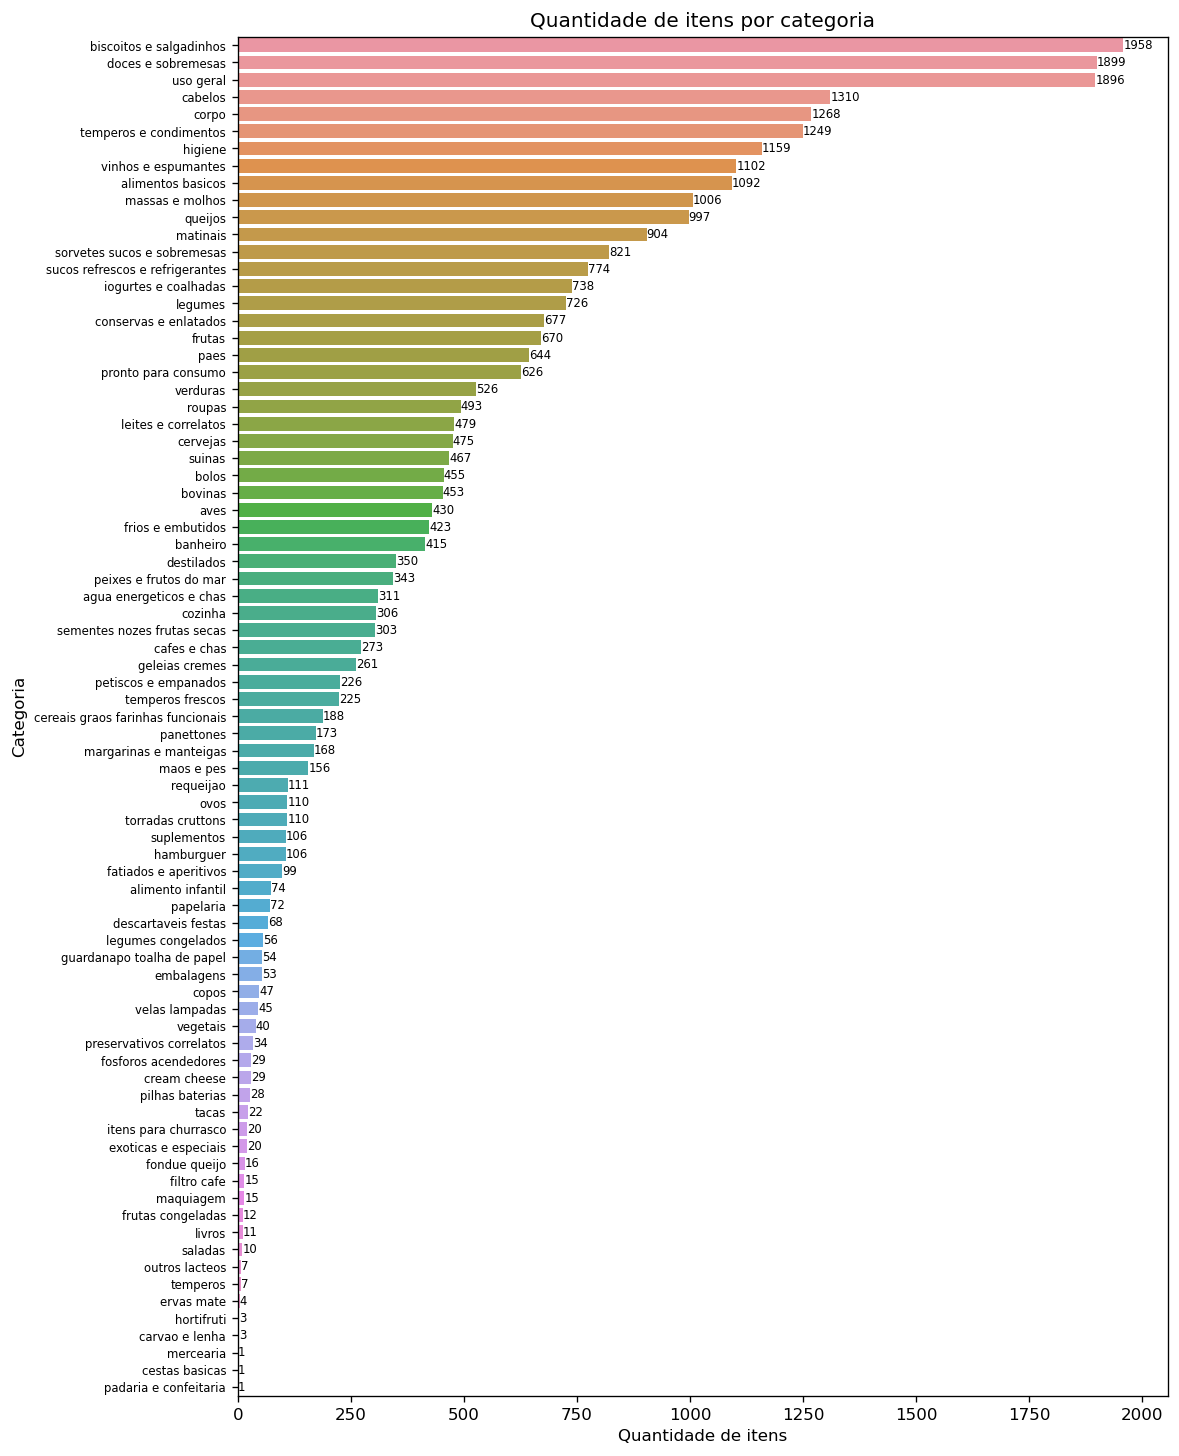

In [163]:
plt.figure(dpi=120,figsize=(10,15))
ax = sns.countplot(data=df,y='categoria',order=df['categoria'].value_counts().index)
ax.set(title='Quantidade de itens por categoria',ylabel='Categoria',xlabel='Quantidade de itens')
plt.yticks(fontsize=7)
ax.bar_label(ax.containers[0],fontsize=7);

Como temos muitos itens nas categorias *biscoitos e salgadinhos* e *doces e sobremesas* que citam o nome de frutas, vamos reduzir a quantidade de itens nelas para a mesma quantidade presente na categoria *frutas*. Esta medida visa evitar que *limao* seja categorizado, por modelo que treinaremos mais à frente, como um biscoito ou um doce, ao invés de uma fruta, por exemplo.<p>O mesmo problema ocorre com as categorias *sucos refrescos e refrigerantes* e *cafes e chas*. Para elas, entretanto, derrubaremos todos os itens que citarem a palavra *limao*.

Vamos reduzir a quantidade de itens nas categorias muito volumosas para que essas classes não dominem o data set. Deixaremos as classes com um máximo de 300 itens.

In [164]:
lim = df[df['categoria'] == 'frutas']
indices = list()

dados = df[df['categoria'] == 'biscoitos e salgadinhos']
indices.extend(list(dados.sample(len(dados) - len(lim)).index))

dados = df[df['categoria'] == 'doces e sobremesas']
indices.extend(list(dados.sample(len(dados) - len(lim)).index))

dados = df[(df['categoria'] == 'sucos refrescos e refrigerantes') & (df['produto'].str.contains('limao'))]
indices.extend(list(dados.index))

dados = df[(df['categoria'] == 'cafes e chas') & (df['produto'].str.contains('limao'))]
indices.extend(list(dados.index))

df.drop(indices,inplace=True)

Vamos confirmar o êxito da redução

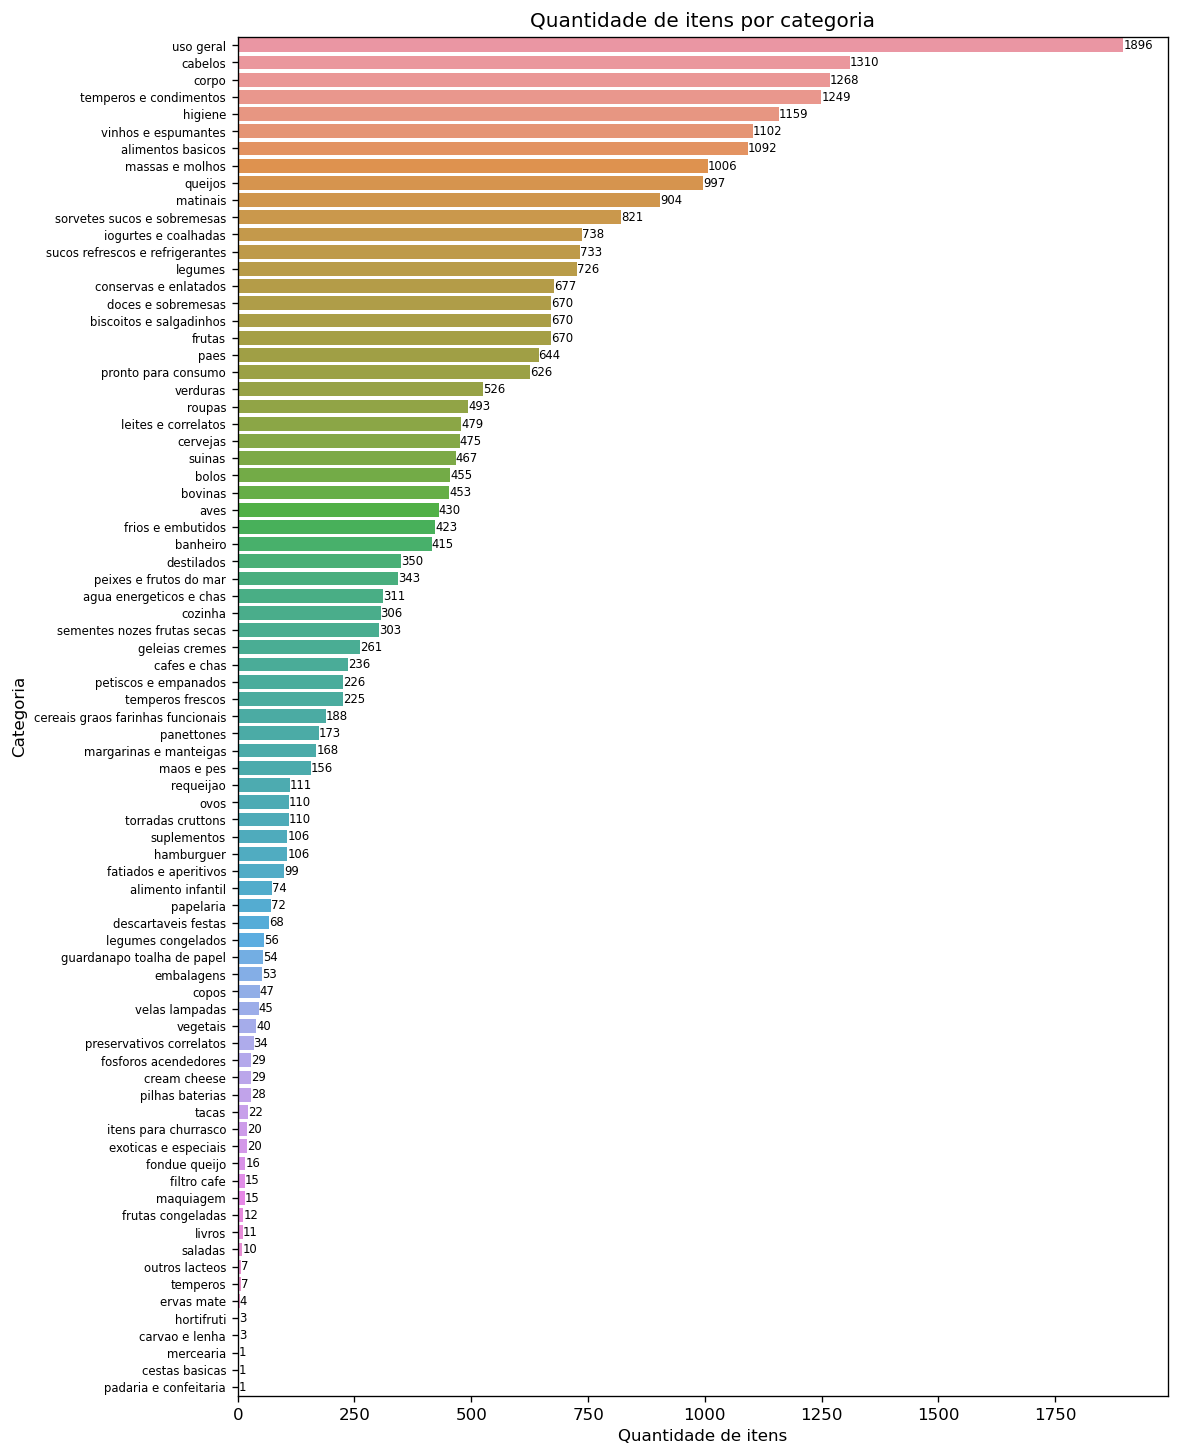

In [165]:
plt.figure(dpi=120,figsize=(10,15))
ax = sns.countplot(data=df,y='categoria',order=df['categoria'].value_counts().index)
ax.set(title='Quantidade de itens por categoria',ylabel='Categoria',xlabel='Quantidade de itens')
plt.yticks(fontsize=7)
ax.bar_label(ax.containers[0],fontsize=7);

# Salvando os dados em arquivo .csv

In [166]:
df.sort_values(by='produto',inplace=True) # Para misturar os produtos dos diferentes mercados entre si.
df.to_csv('arquivos/produtos_categorias.csv',index=False)